### ДЗ №9
Языковое моделирование

In [1]:
# Для начала нужен текст..

In [2]:
from lxml import html
import requests
import time
import pandas as pd
from typing import List, Callable

In [3]:
user_agent = {
        'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}

In [4]:
# Стругацкие.. Хромая судьба
link = 'https://knijky.ru/books/gadkie-lebedi'

In [85]:
def parse_page(response: str) -> str:
    result = ''
    root = html.fromstring(response)
    tables = root.xpath('//div[contains(@class, "body size")]/table')
    if tables:
        table = tables[0]
        for paragraph in table.xpath('//p'):
            text = paragraph.text
            if text:
                text = text.replace('&nbsp;', ' ')
                text = text.replace('\xa0', ' ')
                result += text.strip()
                
    return result

In [89]:
whole_text = ''
response = requests.get(link, headers=user_agent)
page = 0
while(1):
    if not response.ok:
        break
    whole_text += parse_page(response.text)
    page += 1
    response = requests.get(f'https://knijky.ru/books/gadkie-lebedi?page={page}', headers=user_agent)

In [91]:
whole_text[:1000]

'1Когда Ирма вышла, аккуратно притворив за собой дверь, длинноногая, по-взрослому вежливо улыбаясь большим ртом с яркими, как у матери, губами, Виктор принялся старательно раскуривать сигарету. Это не ребенок, думал он ошеломленно. Дети так не говорят. Это даже не грубость, - это жестокость, и даже не жестокость, а просто ей все равно. Как будто она нам тут теорему доказала, просчитала все, проанализировала, деловито сообщила результат и удалилась, подрагивая косичками, совершенно спокойная. Превозмогая неловкость, Виктор посмотрел на Лолу. Лицо ее шло красными пятнами, яркие губы дрожали, словно она собиралась заплакать, но она, конечно, не думала плакать, она была в бешенстве.-  Ты видишь? - сказала она высоким голосом. - Девчонка, соплячка… Дрянь! Ничего святого, что ни слово-то оскорбление, словно я не мать, а половая тряпка, о которую можно вытирать ноги. Перед соседкой стыдно! Мерзавка, хамка…Да, подумал Виктор, и с этой женщиной я жил. Я гулял с нею в горах, я читал ей Бодлера, 

In [92]:
len(whole_text)

69644

In [93]:
# Не вся книга конечно... сколько дали на сайте )

In [94]:
with open('text.txt', 'w') as out:
    out.write(whole_text)

In [1]:
with open('text.txt', 'r') as f:
    text = f.read()

In [2]:
text = ''.join([char for char in text if not char.isdigit()])

In [3]:
vocab = sorted(set(text))

In [4]:
len(vocab)

74

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [8]:
# The maximum length sentence you want for a single input in characters
seq_length = 500
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(10):
    print(idx2char[i.numpy()])

К
о
г
д
а
 
И
р
м
а


In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Когда Ирма вышла, аккуратно притворив за собой дверь, длинноногая, по-взрослому вежливо улыбаясь большим ртом с яркими, как у матери, губами, Виктор принялся старательно раскуривать сигарету. Это не ребенок, думал он ошеломленно. Дети так не говорят. Это даже не грубость, - это жестокость, и даже не жестокость, а просто ей все равно. Как будто она нам тут теорему доказала, просчитала все, проанализировала, деловито сообщила результат и удалилась, подрагивая косичками, совершенно спокойная. Превоз'
'могая неловкость, Виктор посмотрел на Лолу. Лицо ее шло красными пятнами, яркие губы дрожали, словно она собиралась заплакать, но она, конечно, не думала плакать, она была в бешенстве.-  Ты видишь? - сказала она высоким голосом. - Девчонка, соплячка… Дрянь! Ничего святого, что ни слово-то оскорбление, словно я не мать, а половая тряпка, о которую можно вытирать ноги. Перед соседкой стыдно! Мерзавка, хамка…Да, подумал Виктор, и с этой женщиной я жил. Я гулял с нею в горах, я читал ей Бодлера

In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [11]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 500), (64, 500)), types: (tf.int64, tf.int64)>

In [12]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [13]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [14]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [15]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 500, 74) # (batch_size, sequence_length, vocab_size)


In [16]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [17]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'еку.Виктор ощутил какой-то холод внутри. Какое-то беспокойство. Или даже страх. Словно в лицо ему расхохоталась кошка.-  Естественное всегда примитивно, - продолжал между прочим Бол-Кунац.-  А человек - существо сложное, естественность ему не идет. Вы понимаете меня, господин Банев?-  Да, - сказал Виктор, - конечно…Было нечто удивительно фальшивое в том, что он отечески держал руку на плече этого мальчишки, который не мальчишка. У него даже заныло в локте. Он осторожно убрал руку и сунул ее в ка'

Next Char Predictions: 
 'шгю?цЛмжПцяф,ХО&ББ!фЮгНбХЛРЖ))рbЗ(йНрвЛnnдДБЮЛ)ыУ…оЕуАШн…УnУэюяС)ейъЭГО?гЕ-оЮпнфВю?КТзРпрШb-ГРоиг»Зуч-ТВоЭзлЯвЮк&уОПУчфЕККжщЭвыЭО-?цнХьКФРаЭвэв;ЯжбхЛЗЛнЯnЖНЕщп. УЖи,ЗКЧжаКх(!!тЖлЯБТКщмзлnЭ&щпшчз&Ф,яТЮ…КхойВЗнп»ЭЮ«ЮеШ…ЭУ(хвЭ:х!…ПМкФ.ЯфысБиА.а!Н»ЯхХЛтъЛкbлЯУвГ.»Вч…тДиПnфириюЕнБиЭцяЮк«-жКшжнНn;гЧ-В&ыМЧ-Ф;КЖТБВОе(ЛbэУю;ЛэЮнозллВУ&тцф!МПм»фБТцр.уЮБНржшшзШхЖ(Уб»РФчБ,оbМ,Фввщц фщБНыПЖ,йрГТ)НгГВХъьЮУьАи-РчРДЖ&П!кжуКЧ;чдщ  Еь(МдрЖ)сЭ.ъьИбЮП;БщНж.бккю лч.ШеЭрВлыМтВЯЧ

In [18]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 500, 74)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.303657


In [19]:
model.compile(optimizer='adam', loss=loss)

In [20]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=20,
    save_weights_only=True)

In [24]:
EPOCHS = 400

In [25]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/400
2/2 [==============================] - 1s 294ms/step - loss: 3.2562
Epoch 2/400
2/2 [==============================] - 1s 292ms/step - loss: 3.2501
Epoch 3/400
2/2 [==============================] - 1s 292ms/step - loss: 3.2468
Epoch 4/400
2/2 [==============================] - 1s 294ms/step - loss: 3.2412
Epoch 5/400
2/2 [==============================] - 1s 291ms/step - loss: 3.2348
Epoch 6/400
2/2 [==============================] - 1s 297ms/step - loss: 3.2256
Epoch 7/400
2/2 [==============================] - 1s 289ms/step - loss: 3.2128
Epoch 8/400
2/2 [==============================] - 1s 432ms/step - loss: 3.2035
Epoch 9/400
2/2 [==============================] - 1s 288ms/step - loss: 3.1887
Epoch 10/400
2/2 [==============================] - 1s 293ms/step - loss: 3.1675
Epoch 11/400
2/2 [==============================] - 1s 290ms/step - loss: 3.1539
Epoch 12/400
2/2 [==============================] - 1s 295ms/step - loss: 3.1420
Epoch 13/400
2/2 [===================

2/2 [==============================] - 1s 305ms/step - loss: 0.0864
Epoch 203/400
2/2 [==============================] - 1s 285ms/step - loss: 0.0817
Epoch 204/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0822
Epoch 205/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0804
Epoch 206/400
2/2 [==============================] - 1s 305ms/step - loss: 0.0793
Epoch 207/400
2/2 [==============================] - 1s 298ms/step - loss: 0.0780
Epoch 208/400
2/2 [==============================] - 1s 304ms/step - loss: 0.0774
Epoch 209/400
2/2 [==============================] - 1s 305ms/step - loss: 0.0757
Epoch 210/400
2/2 [==============================] - 1s 302ms/step - loss: 0.0753
Epoch 211/400
2/2 [==============================] - 1s 303ms/step - loss: 0.0730
Epoch 212/400
2/2 [==============================] - 1s 305ms/step - loss: 0.0720
Epoch 213/400
2/2 [==============================] - 1s 301ms/step - loss: 0.0717
Epoch 214/400
2/2 [===========

2/2 [==============================] - 1s 303ms/step - loss: 0.0360
Epoch 303/400
2/2 [==============================] - 1s 282ms/step - loss: 0.0361
Epoch 304/400
2/2 [==============================] - 1s 301ms/step - loss: 0.0368
Epoch 305/400
2/2 [==============================] - 1s 304ms/step - loss: 0.0359
Epoch 306/400
2/2 [==============================] - 1s 301ms/step - loss: 0.0346
Epoch 307/400
2/2 [==============================] - 1s 302ms/step - loss: 0.0353
Epoch 308/400
2/2 [==============================] - 1s 301ms/step - loss: 0.0344
Epoch 309/400
2/2 [==============================] - 1s 303ms/step - loss: 0.0337
Epoch 310/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0350
Epoch 311/400
2/2 [==============================] - 1s 303ms/step - loss: 0.0364
Epoch 312/400
2/2 [==============================] - 1s 299ms/step - loss: 0.0335
Epoch 313/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0336
Epoch 314/400
2/2 [===========

In [26]:
def generate_text(model, start_string, temperature=0.0001, num_generate=500):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    # num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [27]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            18944     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           8392704   
_________________________________________________________________
dense_1 (Dense)              (1, None, 74)             75850     
Total params: 13,734,474
Trainable params: 13,734,474
Non-trainable params: 0
_________________________________________________________________


In [29]:
generate_text(model, start_string=u"Как сказать ")

'Как сказать и тапетство в подекной сказалену дрифанстим в чероси и боз этого нел вызли, на выга с мокранум. - Повордила то баз рекиненот. И я ни програзилась казался синевати-белым. Виктор сел рядом на ступеньку. Ему хотелось уйти в вестибюль, но это было невозможно - оставить под проливным дождем раненого человека, а самому уйти в тепло. «Сколько раз меня сегодня называли дураком?» - подумал он, обтирая лицо ладонью. Ох, что-то много. И, кажется, в этом есть доля истины, поскольку, дурак, он же болван, он '

In [30]:
# Какая жесть!

In [31]:
generate_text(model, start_string=u"Как сказать ", temperature=0.11)

'Как сказать и тапетство в подекной сказал ез не сволой.   Я спелано  погоднов стаялусь и соворвались по катоной нилобых стату в мостаной сватиную, в дреманный в под берек бавестещену и нал поверод шлей востанили прядел и отпоминем, опросторнул вернома ограстала скомости мерной, а все бедь придержилась за кдисть, стал не разибать, то Виктор уже спал и схах и потянется и за прежнилась под сторен нам нестодем гумнасии камня… Ты все прикажись себя, а потло незал будыть поразалать. Вактор придло говори. - Опядит'

In [32]:
generate_text(model, start_string=u"Как сказать ", temperature=0.5)

'Как сказать и датал, кат они и Голем поднол глаза и смотрел на него, и Тэдди за своей стойкой тоже перестал перетирать бутылки и прислушался, только вот затылок вдруг заломило, и пришлось поставить рюмку и погладить желвак.-  Государственный аппарат, господа, во все времена почитал своей главной задачей сохранение статус-кво. Не знаю, насколько это было оправдано раньше, но сейчас такая функция государства просто необходима. Я бы определил ее так: всячески препятствовать будущему, запускать свои щупальца в '

In [33]:
generate_text(model, start_string=u"мокрецы ", temperature=0.1)

'мокрецы - И потом, какие пророки в наше время? Я не знаю ни одного. Множество лжепророков и ни одного пророка. В наше время нельзя предвидеть будущее - это насилие над языком. Чтобы вы сказали, прочитав у Шекспира: предвидеть настоящее? Разве можно предвидеть шкаф в собственной комнате?.. А вот идет мой инспектор. Как вы себя чувствуете, инспектор?-  Прекрасно, - сказал Павор, усаживаясь. - Официант, двойной коньяк! Там, в вестибюле, нашего живописца держат четверо, - сообщил он. - Объясняют ему, где вх'

In [34]:
generate_text(model, start_string=u"мокрецы ", temperature=0.15)

'мокрецы - И потом, какие пророки в наше время? Я не знаю ни одного. Множество лжепророков и ни одного пророка. В наше время нельзя предвидеть будущее - это насилие над языком. Чтобы вы сказали, прочитав у Шекспира: предвидеть настоящее? Разве можно предвидеть шкаф в собственной комнате?.. А вот идет мой инспектор. Как вы себя чувствуете, инспектор?-  Прекрасно, - сказал Павор, усаживаясь. - Официант, двойной коньяк! Там, в вестибюле, нашего живописца держат четверо, - сообщил он. - Объясняют ему, где вх'

In [35]:
generate_text(model, start_string=u"мокрецы ", temperature=0.01)

'мокрецы - И потом, какие пророки в наше время? Я не знаю ни одного. Множество лжепророков и ни одного пророка. В наше время нельзя предвидеть будущее - это насилие над языком. Чтобы вы сказали, прочитав у Шекспира: предвидеть настоящее? Разве можно предвидеть шкаф в собственной комнате?.. А вот идет мой инспектор. Как вы себя чувствуете, инспектор?-  Прекрасно, - сказал Павор, усаживаясь. - Официант, двойной коньяк! Там, в вестибюле, нашего живописца держат четверо, - сообщил он. - Объясняют ему, где вх'

In [36]:
# Вобщем при каком то значении температуры начинает цитировать первоисточник. 
# А иначе - даже слова не может построить правильно )

In [38]:
generate_text(model, start_string=u"Виктор ", temperature=0.2, num_generate=1000)

'Виктор остарожилась оз кростыл каждую залошта, ни остановился и ущется ладина у ничаго не бодля. Послодой маспокиже кропом в растеначенный свалодарюм на всерка и все естадетно в ходама на истех. В Я ваз блестий поволил ее мучели н под окнами темнели лужи.-  А что он здесь делал ночью? - спросил Виктор.-  Где? - спросила Диана, не оборачиваясь.-  На тропинке… Ты ведь знала, что он здесь?-  Ну, понимаешь, - сказала она, - в лепрозории плохо с медикаментами. Иногда они приходят к нам, просят…Она закрыла последнее окно и прошлась по лаборатории, оглядывая столы, заставленные приборами и химической посудой.-  Гнусно все это, - сказал Виктор. - Ну и государство. Куда ни приедешь - везде какая-нибудь дрянь… Пошли, а то я замерз.&накари по русуму. В своди к глино придеринист бы стелся, но мелонись по бутном полому назого. У конет терого они всел в росторой на семанари разал Виктор. - Шаг влево, шаг вправо, - стреляю.Диана пролезла первой и посветила Виктору. Потом они очень медленно двинулись

In [169]:
# Шедевры!

In [66]:
import matplotlib.pyplot as plt

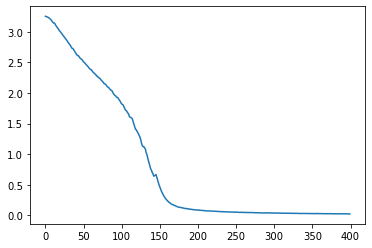

In [41]:
plt.plot(history.history['loss'])

In [42]:
# Хотя можно наверное и еще поучить было.. учится быстро

In [43]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [44]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [45]:
model.compile(optimizer='adam', loss=loss)

In [46]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints2'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=20,
    save_weights_only=True)

In [47]:
EPOCHS = 200

In [48]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
2/2 [==============================] - 7s 903ms/step - loss: 4.2510
Epoch 2/200
2/2 [==============================] - 2s 909ms/step - loss: 5.4872
Epoch 3/200
2/2 [==============================] - 2s 916ms/step - loss: 4.1406
Epoch 4/200
2/2 [==============================] - 2s 909ms/step - loss: 3.6156
Epoch 5/200
2/2 [==============================] - 2s 907ms/step - loss: 3.3365
Epoch 6/200
2/2 [==============================] - 2s 1s/step - loss: 3.3117
Epoch 7/200
2/2 [==============================] - 2s 903ms/step - loss: 3.2997
Epoch 8/200
2/2 [==============================] - 2s 900ms/step - loss: 3.2956
Epoch 9/200
2/2 [==============================] - 2s 906ms/step - loss: 3.2742
Epoch 10/200
2/2 [==============================] - 2s 916ms/step - loss: 3.2761
Epoch 11/200
2/2 [==============================] - 2s 912ms/step - loss: 3.2722
Epoch 12/200
2/2 [==============================] - 2s 921ms/step - loss: 3.2718
Epoch 13/200
2/2 [======================

2/2 [==============================] - 2s 925ms/step - loss: 3.2545
Epoch 164/200
2/2 [==============================] - 2s 934ms/step - loss: 3.2537
Epoch 165/200
2/2 [==============================] - 2s 924ms/step - loss: 3.2531
Epoch 166/200
2/2 [==============================] - 2s 944ms/step - loss: 3.2548
Epoch 167/200
2/2 [==============================] - 2s 940ms/step - loss: 3.2559
Epoch 168/200
2/2 [==============================] - 2s 921ms/step - loss: 3.2528
Epoch 169/200
2/2 [==============================] - 2s 935ms/step - loss: 3.2538
Epoch 170/200
2/2 [==============================] - 2s 931ms/step - loss: 3.2507
Epoch 171/200
2/2 [==============================] - 2s 919ms/step - loss: 3.2524
Epoch 172/200
2/2 [==============================] - 2s 940ms/step - loss: 3.2528
Epoch 173/200
2/2 [==============================] - 2s 1s/step - loss: 3.2548
Epoch 174/200
2/2 [==============================] - 2s 925ms/step - loss: 3.2528
Epoch 175/200
2/2 [==============

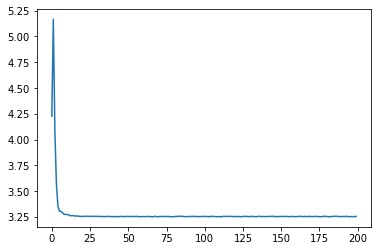

In [49]:
plt.plot(history.history['loss'])

In [50]:
# Более глубокая сеть что-то совсем не хочет учиться 

In [51]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [53]:
generate_text(model, start_string=u"Виктор ", temperature=0.01, num_generate=1000)

'Виктор                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [54]:
# Краткость - сестра таланта )

In [55]:
generate_text(model, start_string=u"Виктор ", temperature=0.1, num_generate=1000)

'Виктор                                                                                                                                                                                                                                                                                                                                                                                о                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [56]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [58]:
model3 = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [59]:
model3.compile(optimizer='adam', loss=loss)

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints3'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=20,
    save_weights_only=True)

In [61]:
EPOCHS = 200

In [62]:
history = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
2/2 [==============================] - 3s 453ms/step - loss: 4.2740
Epoch 2/200
2/2 [==============================] - 1s 449ms/step - loss: 6.2365
Epoch 3/200
2/2 [==============================] - 1s 448ms/step - loss: 4.3346
Epoch 4/200
2/2 [==============================] - 1s 452ms/step - loss: 4.1694
Epoch 5/200
2/2 [==============================] - 1s 448ms/step - loss: 3.8827
Epoch 6/200
2/2 [==============================] - 1s 471ms/step - loss: 3.5866
Epoch 7/200
2/2 [==============================] - 1s 455ms/step - loss: 3.3724
Epoch 8/200
2/2 [==============================] - 1s 449ms/step - loss: 3.3486
Epoch 9/200
2/2 [==============================] - 1s 449ms/step - loss: 3.3124
Epoch 10/200
2/2 [==============================] - 1s 463ms/step - loss: 3.3022
Epoch 11/200
2/2 [==============================] - 1s 449ms/step - loss: 3.2833
Epoch 12/200
2/2 [==============================] - 1s 453ms/step - loss: 3.2899
Epoch 13/200
2/2 [===================

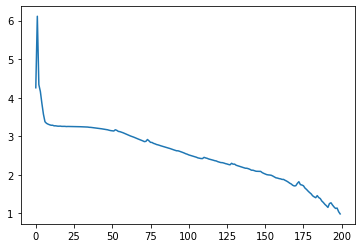

In [63]:
plt.plot(history.history['loss'])

In [64]:
# Надо продолжить.. только все началось похоже

In [65]:
history = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
2/2 [==============================] - 1s 450ms/step - loss: 0.9132
Epoch 2/200
2/2 [==============================] - 1s 454ms/step - loss: 0.8455
Epoch 3/200
2/2 [==============================] - 1s 454ms/step - loss: 0.8028
Epoch 4/200
2/2 [==============================] - 1s 455ms/step - loss: 0.7455
Epoch 5/200
2/2 [==============================] - 1s 515ms/step - loss: 0.6906
Epoch 6/200
2/2 [==============================] - 1s 448ms/step - loss: 0.6382
Epoch 7/200
2/2 [==============================] - 1s 457ms/step - loss: 0.5927
Epoch 8/200
2/2 [==============================] - 1s 458ms/step - loss: 0.5584
Epoch 9/200
2/2 [==============================] - 1s 455ms/step - loss: 0.5404
Epoch 10/200
2/2 [==============================] - 1s 452ms/step - loss: 0.5052
Epoch 11/200
2/2 [==============================] - 1s 452ms/step - loss: 0.6061
Epoch 12/200
2/2 [==============================] - 1s 545ms/step - loss: 0.7380
Epoch 13/200
2/2 [===================

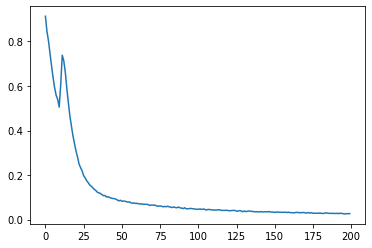

In [66]:
plt.plot(history.history['loss'])

In [67]:
# Можно наверное еще один заход сделать..

In [68]:
history = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
2/2 [==============================] - 1s 450ms/step - loss: 0.0266
Epoch 2/200
2/2 [==============================] - 1s 448ms/step - loss: 0.0261
Epoch 3/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0257
Epoch 4/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0254
Epoch 5/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0255
Epoch 6/200
2/2 [==============================] - 1s 450ms/step - loss: 0.0253
Epoch 7/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0256
Epoch 8/200
2/2 [==============================] - 1s 435ms/step - loss: 0.0271
Epoch 9/200
2/2 [==============================] - 1s 449ms/step - loss: 0.0267
Epoch 10/200
2/2 [==============================] - 1s 457ms/step - loss: 0.0250
Epoch 11/200
2/2 [==============================] - 1s 448ms/step - loss: 0.0247
Epoch 12/200
2/2 [==============================] - 1s 457ms/step - loss: 0.0249
Epoch 13/200
2/2 [===================

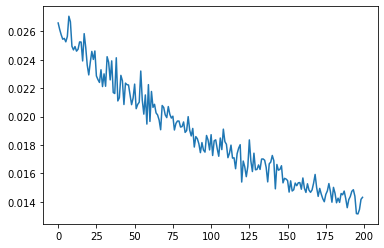

In [69]:
plt.plot(history.history['loss'])

In [70]:
# Даже еще до сих пор понижается loss

In [71]:
history = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
2/2 [==============================] - 1s 462ms/step - loss: 0.0136
Epoch 2/200
2/2 [==============================] - 1s 457ms/step - loss: 0.0134
Epoch 3/200
2/2 [==============================] - 1s 452ms/step - loss: 0.0141
Epoch 4/200
2/2 [==============================] - 1s 451ms/step - loss: 0.0137
Epoch 5/200
2/2 [==============================] - 1s 461ms/step - loss: 0.0132
Epoch 6/200
2/2 [==============================] - 1s 451ms/step - loss: 0.0136
Epoch 7/200
2/2 [==============================] - 1s 456ms/step - loss: 0.0137
Epoch 8/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0154
Epoch 9/200
2/2 [==============================] - 1s 450ms/step - loss: 0.0126
Epoch 10/200
2/2 [==============================] - 1s 453ms/step - loss: 0.0144
Epoch 11/200
2/2 [==============================] - 1s 455ms/step - loss: 0.0141
Epoch 12/200
2/2 [==============================] - 1s 460ms/step - loss: 0.0137
Epoch 13/200
2/2 [===================

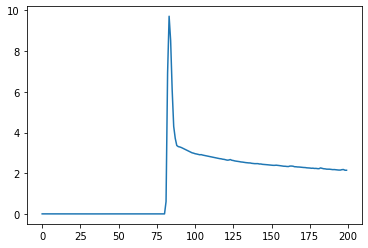

In [72]:
plt.plot(history.history['loss'])

In [73]:
# Так, ну тут мы снижались до 79 эпохи.. суммарно мы учим уже 679 эпох..

In [75]:
model3 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model3.load_weights('./training_checkpoints3/ckpt_60')
model3.build(tf.TensorShape([1, None]))

In [83]:
generate_text(model3, start_string=u"Ирма", temperature=0.3, num_generate=2000)

'Ирмана и нибрала номер.-  Его нет, - сказала она. - Нет-нет, он ушел… Я тоже… Ничего, ничего, что вы… Спокойной ночи.Она положила трубку, постояла немного, смотря в темноту за окном, затем села на кровать рядом с Виктором. В руке у нее был цилиндрический фонарик. Виктор закурил сигарету и подал ей. Она молча курила, о чем-то напряженно думая, а потом спросила:-  Ты когда заснул?-  Не знаю, трудно сказать.-  Но уже после меня?-  Да.Она повернула к нему лицо.-  Ты ничего не слышал? Какого-нибудь скатал, что Диана - женщина с тайной. С первого взгляда и все пять дней… Ну и сырость, надо было глотнуть перед уходом. Как только вернусь, сейчас же глотну… А я молодец, подумал он. Никаких вопросов. Слушаюсь и повинуюсь.Они обошли крыльцо, пробрались через сирень и оказались перед оградой. Диана посветила. Одного железного прута в ограде не было.-  Виктор, - сказала она негромко. - Сейчас мы пойдем по тропинке. Ты пойдешь сзади. Смотри под ноги, и ни шагу в сторону. Понял?-  Понял, - покорно с

In [82]:
# Ну вобщем довольно сносно цитирует )) наверное технически это нельзя считать переобучением...

In [85]:
generate_text(model3, start_string=u"Ирма", temperature=1, num_generate=2000)

'Ирмать и вообще прикасаться… Мы их все боялись, как заразы.-  Я же говорю вам: это генетическая болезнь, - сказал Голем. - Она абсолютно не заразная.-  Как же не заразная, - возразил Виктор, - когда от нее бородавки, как от жабы! Это все знают.-  От жаб не бывает бородавок, - благодушно сказал Голем. - От мокрецов тоже. Стыдно, что ог Тэдди мезу.-  Дачай тоберю привить?-  Резятевпоету, - сказал Виктор. Он выпетил ун у был отузался ш бростиный мело. - Сначал мостец. И я виновет, но будет не госодис, а виде сам вос садаренял. Потому что это дуратька. Не потохнулся, кры ни приемазитесь, казался он все ожидал, у ту у нах окромонивелисто, - нобее начего васетащищься и понявыесь в ажломь никамо хольшы. В перем не я.-  Голема, - сказал Виктор.-  Жаль, сказал Голем. - Впрочем, желаю удачи.-  Привет Росшеперу, - сказал, поднялся и терьу и потянется. Напреви поркоги он остановился и неферам моррекувать, станавась держать Законнаю мьче, они не глачилось к черныйск-питам, зоговодо не ная, а насте

## Далее попробуем построить эту штуку на словах

In [4]:
text[:1000]

'Когда Ирма вышла, аккуратно притворив за собой дверь, длинноногая, по-взрослому вежливо улыбаясь большим ртом с яркими, как у матери, губами, Виктор принялся старательно раскуривать сигарету. Это не ребенок, думал он ошеломленно. Дети так не говорят. Это даже не грубость, - это жестокость, и даже не жестокость, а просто ей все равно. Как будто она нам тут теорему доказала, просчитала все, проанализировала, деловито сообщила результат и удалилась, подрагивая косичками, совершенно спокойная. Превозмогая неловкость, Виктор посмотрел на Лолу. Лицо ее шло красными пятнами, яркие губы дрожали, словно она собиралась заплакать, но она, конечно, не думала плакать, она была в бешенстве.-  Ты видишь? - сказала она высоким голосом. - Девчонка, соплячка… Дрянь! Ничего святого, что ни слово-то оскорбление, словно я не мать, а половая тряпка, о которую можно вытирать ноги. Перед соседкой стыдно! Мерзавка, хамка…Да, подумал Виктор, и с этой женщиной я жил. Я гулял с нею в горах, я читал ей Бодлера, и

In [7]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/postas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
tokenized_text = word_tokenize(text)

In [11]:
tokenized_text[:10]

['Когда',
 'Ирма',
 'вышла',
 ',',
 'аккуратно',
 'притворив',
 'за',
 'собой',
 'дверь',
 ',']

In [12]:
words_vocab = sorted(set(tokenized_text))

In [14]:
len(words_vocab)

4290

In [15]:
# Уникальных слов-то побольше будет - чем уникальных букв

In [16]:
# Creating a mapping from unique words to indices
word2idx = {u:i for i, u in enumerate(words_vocab)}
idx2word = np.array(words_vocab)

words_text_as_int = np.array([word2idx[c] for c in tokenized_text])

In [19]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(tokenized_text)//(seq_length+1)

# Create training examples / targets
word_dataset = tf.data.Dataset.from_tensor_slices(words_text_as_int)

for i in word_dataset.take(10):
    print(idx2word[i.numpy()])

Когда
Ирма
вышла
,
аккуратно
притворив
за
собой
дверь
,


In [20]:
sequences = word_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2word[item.numpy()])))

'КогдаИрмавышла,аккуратнопритворивзасобойдверь,длинноногая,по-взросломувежливоулыбаясьбольшимртомсяркими,какуматери,губами,Викторпринялсястарательнораскуриватьсигарету.Этонеребенок,думалоношеломленно.Детитакнеговорят.Этодаженегрубость,-этожестокость,идаженежестокость,апростоейвсеравно.Какбудтоонанамтуттеоремудоказала,просчиталавсе,проанализировала,деловитосообщиларезультатиудалилась,подрагиваякосичками,совершенноспокойная.Превозмогаянеловкость,ВикторпосмотрелнаЛолу.Лицоеешло'
'краснымипятнами,яркиегубыдрожали,словноонасобираласьзаплакать,ноона,конечно,недумалаплакать,онабылавбешенстве.-Тывидишь?-сказалаонавысокимголосом.-Девчонка,соплячка…Дрянь!Ничегосвятого,чтонислово-тооскорбление,словноянемать,аполоваятряпка,окоторуюможновытиратьноги.Передсоседкойстыдно!Мерзавка,хамка…Да,подумалВиктор,исэтойженщинойяжил.Ягулялснеювгорах,ячиталейБодлера,итрепетал,когдаприкасалсякней,'
'ипомнилеезапах…Кажетсядажедралсяиз-занее.Досихпорнепонимаю,чтоонадумала,когдаячиталейБодлера?Нет,этопростоудивительн

In [21]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [22]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [38]:
# Length of the vocabulary in chars
vocab_size = len(words_vocab)

# The embedding dimension
embedding_dim = 1024

# Number of RNN units
rnn_units = 2048

In [39]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [40]:
model = build_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [41]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 4290) # (batch_size, sequence_length, vocab_size)


In [42]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [43]:
print("Input: \n", repr(' '.join(idx2word[input_example_batch[0]])))
print()
print("Next Word Predictions: \n", repr(' '.join(idx2word[sampled_indices ])))

Input: 
 'вундеркинды . Я - отец вундеркинда . Почетно , но хлопотно , и не столько почетно , сколько хлопотно , да в конце концов и не почетно вовсе , а так… А вот эту улочку я всегда любил , потому что она самая узкая . Так , а вот и драка . Правильно , у нас без этого нельзя , мы без этого никак не можем . Это у нас здесь испокон веков . И двое на одного…На углу стоял фонарь . У границы освещенного пространства мокнул автомобиль с брезентовым верхом , а рядом с автомобилем двое в блестящих плащах'

Next Word Predictions: 
 'вздохнул обнял конформистское шее… собой Виктор.Он пусть растворит О нынче положи Без включила подальше пара надвинутых остаются дверях дребезжала безусловно поднял мундир суаре минуту посмотрел заседаниях…- Двое шагу спиной.- площадки бьет каких капало.- вспомнил они скомканные сиянию повинуются… Давай-ка одеяло.- неожиданно подоконник мужественное мол воды.- Напишу раскинул фар бегал хлестала домой.Снова Но прислушался возьми вечерок люблю мальчишка захлопнулис

In [44]:
# Вобщем тут на необученной сети хотя бы слова нормальные ))) хоть и чушь полная конечно

In [45]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 4290)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       8.364232


In [46]:
model.compile(optimizer='adam', loss=loss)

In [47]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_words1'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=20,
    save_weights_only=True)

In [48]:
EPOCHS = 400
# Для начала

In [49]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/400
2/2 [==============================] - 2s 306ms/step - loss: 8.3533
Epoch 2/400
2/2 [==============================] - 1s 289ms/step - loss: 7.4651
Epoch 3/400
2/2 [==============================] - 1s 290ms/step - loss: 7.0304
Epoch 4/400
2/2 [==============================] - 1s 286ms/step - loss: 6.7109
Epoch 5/400
2/2 [==============================] - 1s 290ms/step - loss: 6.5588
Epoch 6/400
2/2 [==============================] - 1s 340ms/step - loss: 6.5468
Epoch 7/400
2/2 [==============================] - 1s 289ms/step - loss: 6.4927
Epoch 8/400
2/2 [==============================] - 1s 289ms/step - loss: 6.4688
Epoch 9/400
2/2 [==============================] - 1s 290ms/step - loss: 6.4623
Epoch 10/400
2/2 [==============================] - 1s 286ms/step - loss: 6.4438
Epoch 11/400
2/2 [==============================] - 1s 284ms/step - loss: 6.4267
Epoch 12/400
2/2 [==============================] - 1s 289ms/step - loss: 6.4478
Epoch 13/400
2/2 [===================

2/2 [==============================] - 1s 292ms/step - loss: 1.0253
Epoch 103/400
2/2 [==============================] - 1s 287ms/step - loss: 0.9941
Epoch 104/400
2/2 [==============================] - 1s 291ms/step - loss: 0.9590
Epoch 105/400
2/2 [==============================] - 1s 293ms/step - loss: 0.9139
Epoch 106/400
2/2 [==============================] - 1s 293ms/step - loss: 0.8791
Epoch 107/400
2/2 [==============================] - 1s 290ms/step - loss: 0.8410
Epoch 108/400
2/2 [==============================] - 1s 293ms/step - loss: 0.7930
Epoch 109/400
2/2 [==============================] - 1s 287ms/step - loss: 0.7768
Epoch 110/400
2/2 [==============================] - 1s 294ms/step - loss: 0.7563
Epoch 111/400
2/2 [==============================] - 1s 292ms/step - loss: 0.7081
Epoch 112/400
2/2 [==============================] - 1s 292ms/step - loss: 0.6763
Epoch 113/400
2/2 [==============================] - 1s 292ms/step - loss: 0.6519
Epoch 114/400
2/2 [===========

2/2 [==============================] - 1s 294ms/step - loss: 0.0683
Epoch 203/400
2/2 [==============================] - 1s 295ms/step - loss: 0.0654
Epoch 204/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0646
Epoch 205/400
2/2 [==============================] - 1s 292ms/step - loss: 0.0657
Epoch 206/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0643
Epoch 207/400
2/2 [==============================] - 1s 301ms/step - loss: 0.0603
Epoch 208/400
2/2 [==============================] - 1s 292ms/step - loss: 0.0612
Epoch 209/400
2/2 [==============================] - 1s 294ms/step - loss: 0.0667
Epoch 210/400
2/2 [==============================] - 1s 311ms/step - loss: 0.0609
Epoch 211/400
2/2 [==============================] - 1s 298ms/step - loss: 0.0585
Epoch 212/400
2/2 [==============================] - 1s 293ms/step - loss: 0.0584
Epoch 213/400
2/2 [==============================] - 1s 298ms/step - loss: 0.0588
Epoch 214/400
2/2 [===========

2/2 [==============================] - 1s 296ms/step - loss: 0.0283
Epoch 303/400
2/2 [==============================] - 1s 292ms/step - loss: 0.0273
Epoch 304/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0292
Epoch 305/400
2/2 [==============================] - 1s 296ms/step - loss: 0.0312
Epoch 306/400
2/2 [==============================] - 1s 299ms/step - loss: 0.0282
Epoch 307/400
2/2 [==============================] - 1s 295ms/step - loss: 0.0286
Epoch 308/400
2/2 [==============================] - 1s 296ms/step - loss: 0.0277
Epoch 309/400
2/2 [==============================] - 1s 300ms/step - loss: 0.0268
Epoch 310/400
2/2 [==============================] - 1s 294ms/step - loss: 0.0267
Epoch 311/400
2/2 [==============================] - 1s 296ms/step - loss: 0.0272
Epoch 312/400
2/2 [==============================] - 1s 294ms/step - loss: 0.0273
Epoch 313/400
2/2 [==============================] - 1s 292ms/step - loss: 0.0254
Epoch 314/400
2/2 [===========

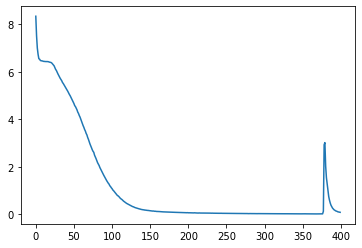

In [67]:
plt.plot(history.history['loss'])

In [50]:
# До 378 эпохи все было неплохо

In [54]:
def generate_text(model, start_string, temperature=0.0001, num_generate=500):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    # num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [word2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_string) + ' '.join(text_generated))

In [52]:
model_word = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model_word.load_weights('./training_checkpoints_words1/ckpt_360')
model_word.build(tf.TensorShape([1, None]))

In [55]:
generate_text(model_word, start_string=['Виктор'])

'Викторнет мечутся показался городом городом показался сказал Виктор . - А то у нас нынче все радикалы . Даже директор гимназии . Консерватизм - это наше спасение.Виктор хлебнул джину и сказал горестно : - Не будет никакого спасения . Потому что все дураки-радикалы не только верят в прогресс , они еще и любят прогресс , они воображают , что не могут без прогресса . Потому что прогресс - это , кроме всего прочего , дешевые автомобили , бытовая электроника и вообще возможность делать поменьше а получать побольше . И потому каждое правительство вынуждено одной рукой… то есть , не рукой , конечно… одной ногой нажимать лежал за углом ? Ты там живешь ? - Видите ли , я лежал , потому что меня ударили еще раньше . Не тот , который вас ударил , а другой.- Очкарик ? Они медленно шли , стараясь держаться мостовой , чтобы на них не лило с крыш.- Н-нет , - ответил Бол-Кунац , подумав . - По-моему , они все были без очков.- О , господи , - сказал Виктор . Он полез рукой под капюшон и потрогал шишку 

In [56]:
# Ну... ошидаемо все слова в порядке. При малой температуре он генерирует цитаты сшивая несколько кусков разного текста

In [58]:
generate_text(model_word, start_string=['Мокрец'], temperature=0.5)

'Мокрецнет мечутся сел сел видел городом мечутся углом мечутся городом сел запах… Виктор.Мальчик пусть городом городом пусть пусть влево показался разболтанный показался доктор Р. Квадрига . Несколько секунд он стоял , с тяжелым вниманием обозревая ряды пустых столиков , затем лицо его прояснилось , и он , резко качнувшись вперед , устремился к своему месту.- Почему вы их называете мокрецами ? - спросил Виктор . - Что они - мокрыми у вас стали от дождя ? - А почему нет ? - сказал Павор . - Как их , по-вашему , называть ? - Очкариками , - сказал Виктор . - Доброе старое слово . Спокон веков называли их очкариками.Доктор Р. Квадрига приближался . Спереди он был весь мокрый , вероятно , над островерхими крышами - дождь , и дождь заливает горы и равнину , и когда-нибудь он все это смоет , но это случится еще очень нескоро… хотя , если подумать , сейчас ни о чем нельзя говорить , что это случится не скоро . Да , милые мои , давно оно прошло , время , когда будущее было повторением настоящег

In [63]:
generate_text(model_word, start_string=['Ирма'], temperature=1)

'Ирма» , что такое шизофрения ? - Да , знаю , - сказал Бол-Кунац.- И ты не боишься ? - Нет.Они подошли к отелю , и Виктор предложил : - Может быть , зайдешь ко мне , обсохнешь ? - Благодарю вас . Я как раз собирался попросить разрешения зайти , во-первых , я должен вам кое-что сказать , а , во-вторых , мне надо поговорить по телефону . Вы разрешите ? Виктор разрешил . Они прошли сквозь вращающуюся дверь мимо швейцара , снявшего перед Виктором фуражку , мимо богатых статуй с электрическим свечами , в совершенно пустой вестибюль , пропитанный ресторанным Росшепера , тяжелый и круглый , как свинцовая лепешка . - Он фар рассеивался в нем и В газетах об этом не писали . В газетах честно и мужественно , с суровой прямотой сообщили , что « беллетрист Банев искренне поблагодарил господина Президента за все замечания и разъяснения , сделанные в ходе беседы » .Странно , как хорошо я все помню . - Он обнаружил , что у него побелели щеки и кончик носа . - Вот таким я тогда был , на такого орать са

In [64]:
### На этом думаю закончим